Introduction: Two-Sigma Financial Modelling Challenge of Kaggle

The data set contains anonymized features pertaining to a time-varying value for a financial instrument. Each instrument has an id. Time is represented by the 'timestamp' feature and the variable to predict is 'y' (likely asset returns). No further information is provided on the meaning of the features or the type of instruments that are included in the data. Number of features: 108; Length of data: about 5 years. We need to use the training data to predict the values of 'y'. https://www.kaggle.com/c/two-sigma-financial-modeling/data

There is abundance of collinearity and large amount of missing values (>20%) in the training data. To address each of the problems:

1) Since collinearity makes the features dependent on each other and the least square assumption, beta^T = (X^T X)^(-1)(X^T Y), will break breakdown and produce very large beta, our model will have very low tolerance of testing error (i.e., small noise in the testing variables can cause large prediction error). We can orthogonalize the features (e.g., principal component) or penalize large betas by regularization (e.g., ridge or lasso regression);

2) For missing values we may fill the data by sklearn's preprocessing functions such as MinMaxScaler or StandardScaler. Actually, in this problem MinMaxScaler gives better results perhaps due to the existence of large outliers.

Given the large amount of samples and relatively small number of features, I divided the data set into two parts: the model is trained on the first 60% of data (about 3 years) and is applied towards the last 40% at each timestamp, generating predictions of y real-time (as in actual trading/investment strategies). The model is scored by r^2 at each timestamp.

I tried both principal components and ridge regressions. Their results are summarized as follows:

1) 17 principal components explain 90% of variance while using all PCs worsens the prediction scores. Strong collearity may render the PCs with smaller variance unstable. 
2) Pincipal component method on average gives better prediction score than ridge regression. However, the best score of ridge regression is much higher than that of principal component.  
3) Under high penalty, ridge regression suppresses the coefficients of many features but two: 'technical_20' and 'technical_30'. This accidental finding is consistent with other users' observations, such as this analysis on the physical meaning of the two features: https://www.kaggle.com/chenjx1005/physical-meanings-of-technical-20-30

The results of PC and Ridge are published separately.

This notebook explores further on why 'technical_20' and 'technical_30' seem to be good predictors of 'y'.


In [1]:
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 6.0
plt.rcParams['ytick.labelsize'] = 6.0

In [3]:
df = pd.HDFStore('../Data/train.h5','r').get("train")

In [8]:
print("Number of Ids:%d"%len(df.id.unique()))
print("Dimension of data set:",df.shape)
print("Number of Time stamps:%d"%len(df.timestamp.unique()))
df.head(20)

Number of Ids:1424
Dimension of data set: (1710756, 111)
Number of Time stamps:1813


,id,timestamp,derived_0,derived_1,derived_2,derived_3,derived_4,fundamental_0,fundamental_1,fundamental_2,...,technical_36,technical_37,technical_38,technical_39,technical_40,technical_41,technical_42,technical_43,technical_44,y
0,10,0,0.370326,-0.006316,0.222831,-0.213030,0.729277,-0.335633,0.113292,1.621238,...,0.775208,NaN,NaN,NaN,-0.414776,NaN,NaN,-2.0,NaN,-0.011753
1,11,0,0.014765,-0.038064,-0.017425,0.320652,-0.034134,0.004413,0.114285,-0.210185,...,0.025590,NaN,NaN,NaN,-0.273607,NaN,NaN,-2.0,NaN,-0.001240
2,12,0,-0.010622,-0.050577,3.379575,-0.157525,-0.068550,-0.155937,1.219439,-0.764516,...,0.151881,NaN,NaN,NaN,-0.175710,NaN,NaN,-2.0,NaN,-0.020940
3,25,0,NaN,NaN,NaN,NaN,NaN,0.178495,NaN,-0.007262,...,1.035936,NaN,NaN,NaN,-0.211506,NaN,NaN,-2.0,NaN,-0.015959
4,26,0,0.176693,-0.025284,-0.057680,0.015100,0.180894,0.139445,-0.125687,-0.018707,...,0.630232,NaN,NaN,NaN,-0.001957,NaN,NaN,0.0,NaN,-0.007338
5,27,0,0.346856,0.166239,-6.080701,-0.992249,-0.125916,0.345812,NaN,-0.584239,...,-0.379366,NaN,NaN,NaN,-0.001957,NaN,NaN,-2.0,NaN,0.031425
6,31,0,0.072036,0.014931,NaN,0.014063,NaN,-0.193205,NaN,NaN,...,1.232558,NaN,NaN,NaN,0.350685,NaN,NaN,-2.0,NaN,-0.032895
7,38,0,0.300062,0.071251,-0.074451,-0.065292,-0.011286,0.026365,0.210249,0.167494,...,0.242646,NaN,NaN,NaN,-0.168077,NaN,NaN,-2.0,NaN,0.015803
8,39,0,-0.003511,-0.034270,0.082372,-0.023937,-0.025750,0.007815,0.263451,-0.241212,...,0.186175,NaN,NaN,NaN,-0.300842,NaN,NaN,-2.0,NaN,-0.027593
9,40,0,-0.083330,0.081935,-2.048438,-0.206856,-0.839563,-0.234100,-0.291853,-5.722336,...,-0.021965,NaN,NaN,NaN,-0.386579,NaN,NaN,-2.0,NaN,0.006662


There are many NaN values so let's take a look:

<Container object of 108 artists>

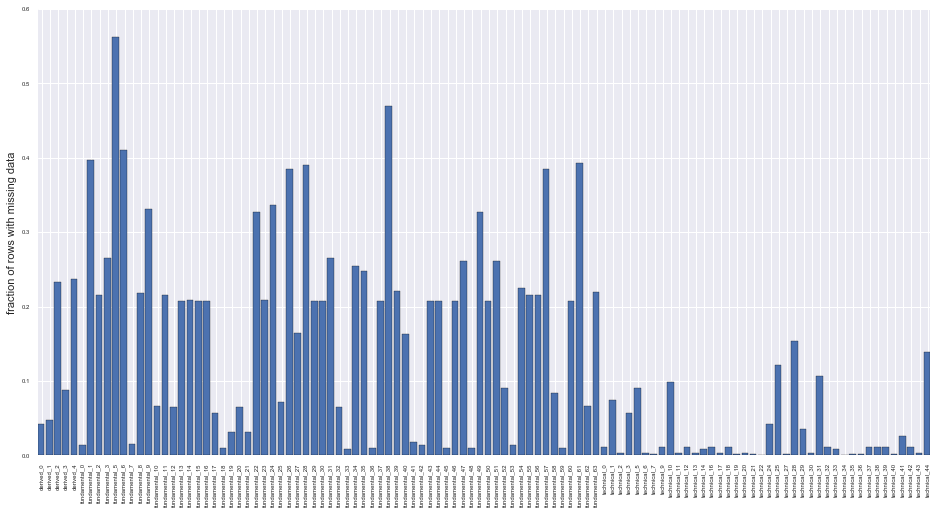

In [10]:
cols = df.columns.drop(['timestamp','id','y'])
null_counts = df[cols].isnull().sum()/len(df)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
plt.ylabel('fraction of rows with missing data')
plt.bar(np.arange(len(null_counts)),null_counts)

Sort the features by fraction of missing data. 

In [11]:
null_counts.sort()
null_counts.head(20) 

/Users/langong/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  if __name__ == '__main__':


technical_34      0.000000
technical_22      0.000000
technical_21      0.001307
technical_40      0.001307
technical_7       0.001307
technical_19      0.001356
technical_27      0.001415
technical_36      0.001492
technical_35      0.001844
technical_6       0.002501
technical_2       0.002501
technical_11      0.002501
technical_17      0.002501
technical_43      0.002739
technical_20      0.002785
technical_13      0.002785
technical_30      0.002785
fundamental_33    0.008087
technical_14      0.008291
technical_33      0.008496
dtype: float64

<Container object of 108 artists>

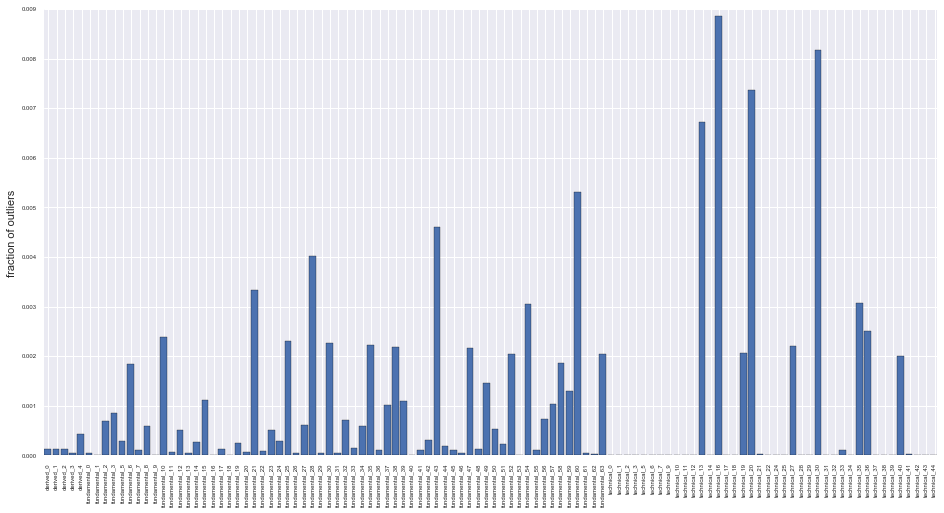

In [18]:
outlier_counts = df[cols].apply(lambda x: x > 5 * x.std(),axis=0).sum()/len(df)
plt.figure(figsize=(16,8))
plt.xticks(np.arange(len(outlier_counts))+0.5,outlier_counts.index,rotation='vertical')
plt.ylabel('fraction of outliers')
plt.bar(np.arange(len(outlier_counts)),outlier_counts)

From fraction of missing values and outliers, features with name 'technical_*' have the least amount of missing values and higher number of outliers. However, the largest fraction of outliers is less than 1%. 
So we may conclude that the 'technical_*' features are the most useful as they are more liquid.

Since 'posteriori' we know that technical_20 and technical_30 are somehow special. So next let's see how they are related to 'y'.

In [3]:
cols = df.columns.drop(['timestamp','id','y'])
grp = df.groupby('timestamp')
grp_mean = grp.mean()
grp_var = grp.var()
corr_xy = {}
var = {}

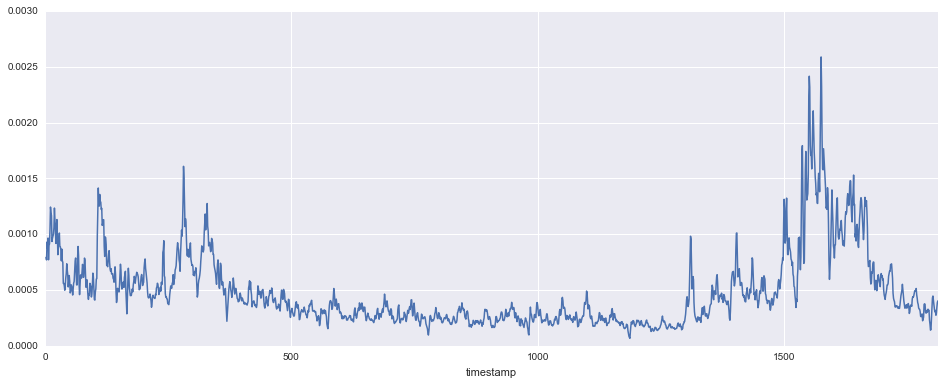

In [14]:
var['y'] = grp_var['y'].rolling(window=3).mean()
var['technical_20'] = grp_var['technical_20'].rolling(window=3).mean()
var['technical_30'] = grp_var['technical_30'].rolling(window=3).mean()
pd.Series(var['y']).plot(lw=1.5,figsize=(16,6),fontsize=10)

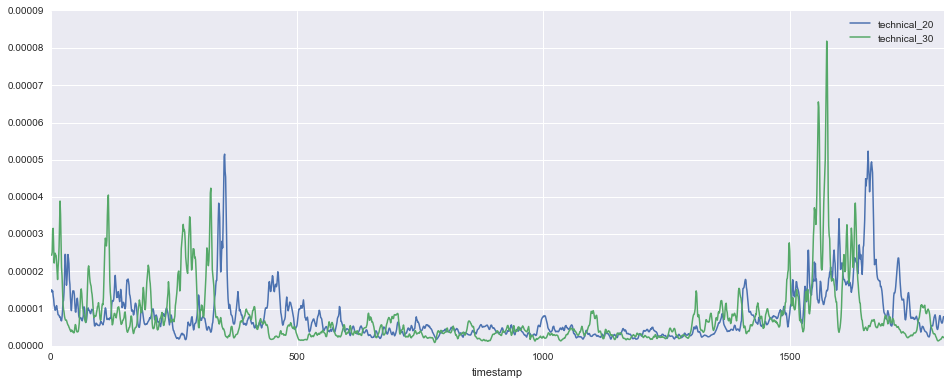

In [15]:
pd.DataFrame(var)[['technical_20','technical_30']].plot(lw=1.5,figsize=(16,6),fontsize=10)

The variance of technical_20 and technical_30 individually is quite close to that of y.
How about the mean of their variances?

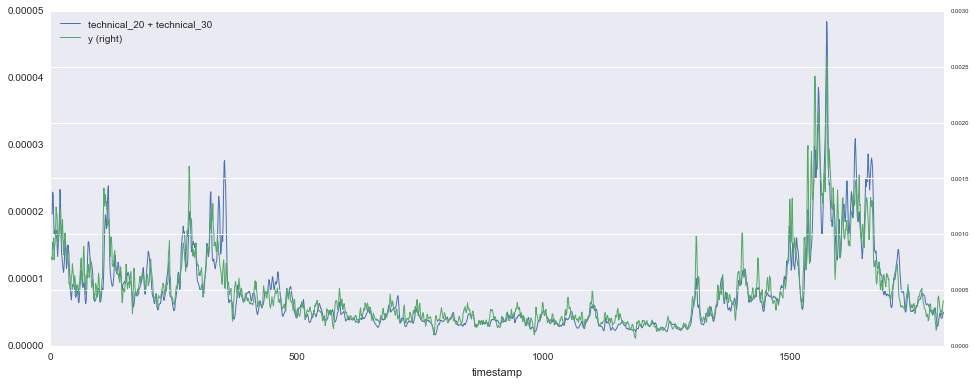

In [16]:
var['technical_20 + technical_30'] = (var['technical_20'] + var['technical_30'])/2.0
pd.DataFrame(var)[['technical_20 + technical_30','y']].plot(lw=1,figsize=(16,6),fontsize=10,secondary_y=['y'])

Mean of the variances of technical_20 and technical_30 almost exactly predicts that of y.
Correlation between these two features and y below suggests they are anti-correlated, consistent with results of Ridge regression.

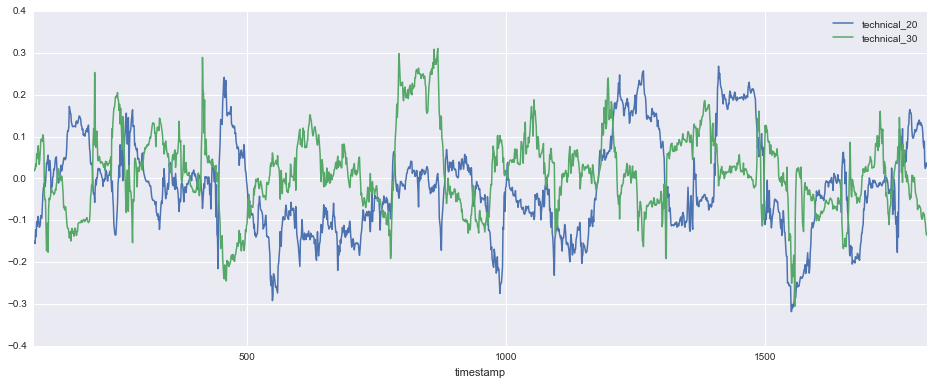

In [59]:
corr_xy['technical_20'] = grp_mean['technical_20'].rolling(window=90).corr(grp_mean['y'],pairwise=True)
corr_xy['technical_30'] = grp_mean['technical_30'].rolling(window=90).corr(grp_mean['y'],pairwise=True)
pd.DataFrame(corr_xy)[['technical_20','technical_30']].dropna().plot(lw=1.5,figsize=(16,6),fontsize=10)

Now let's define a new variable 'x' as the difference between technical_20 and technical_30.
Given that the data is very noisy,I tried different windows of rolling mean of y and compared with x.
Eventually, it seems 14-day rolling mean of y is the best match.

In [7]:
x = (grp_mean['technical_20'] - grp_mean['technical_30'])
x.name = 'technical_20 - technical_30'

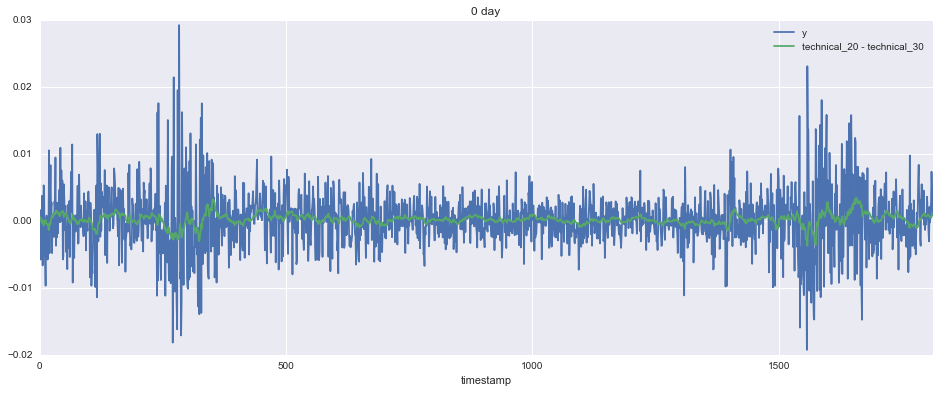

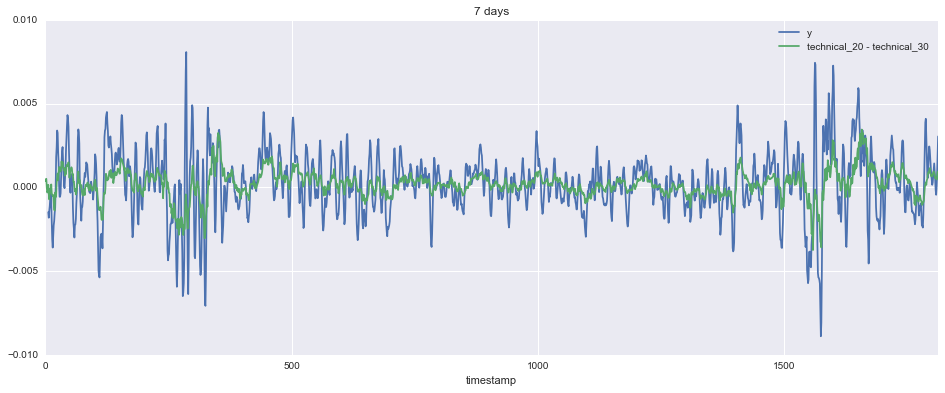

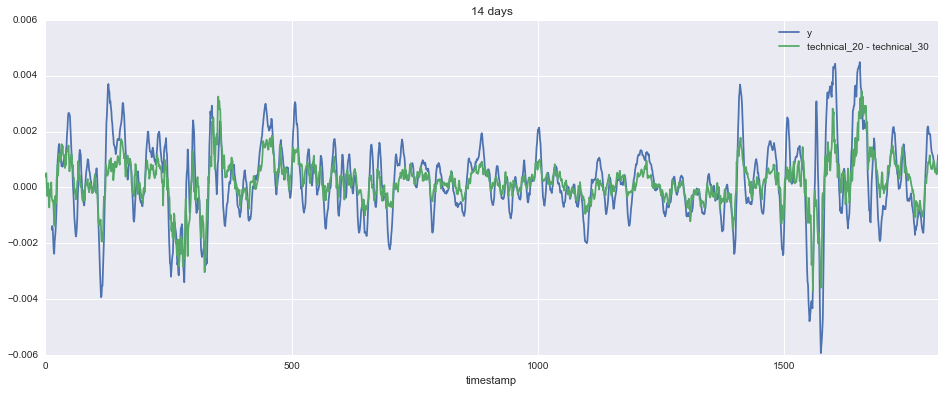

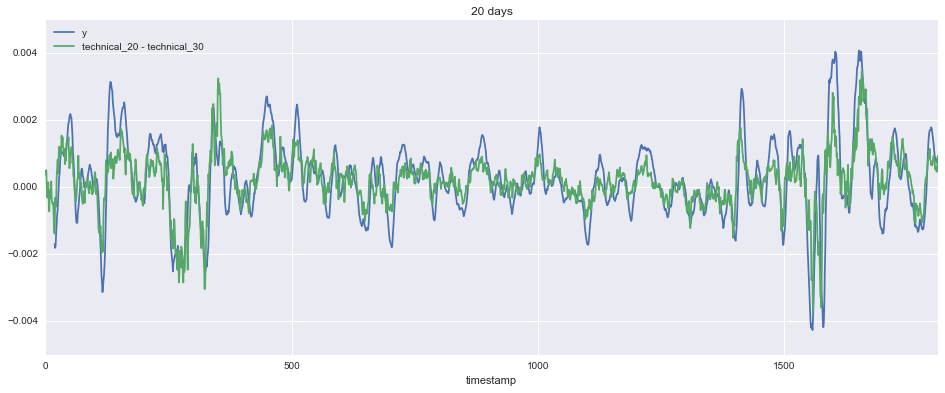

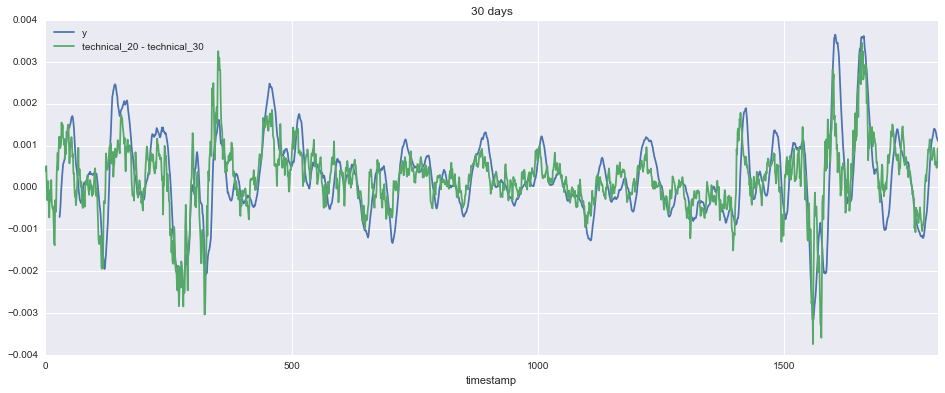

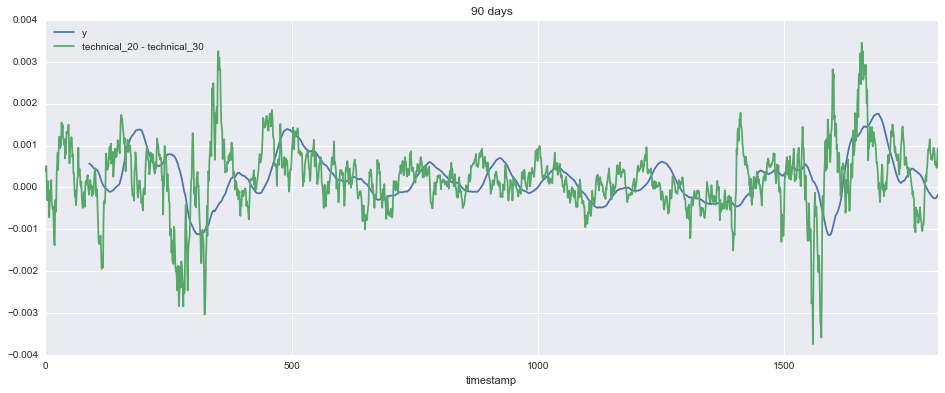

In [13]:
y = grp_mean['y']
pd.concat([y,x],axis=1).plot(figsize=(16,6),fontsize=10,title='0 day')
y = grp_mean['y'].rolling(window=7,win_type='triang').mean()
pd.concat([y,x],axis=1).plot(figsize=(16,6),fontsize=10,title='7 days')
y = grp_mean['y'].rolling(window=14,win_type='triang').mean()
pd.concat([y,x],axis=1).plot(figsize=(16,6),fontsize=10,title='14 days')
y = grp_mean['y'].rolling(window=20,win_type='triang').mean()
pd.concat([y,x],axis=1).plot(figsize=(16,6),fontsize=10,title='20 days')
y = grp_mean['y'].rolling(window=30,win_type='triang').mean()
pd.concat([y,x],axis=1).plot(figsize=(16,6),fontsize=10,title='30 days')
y = grp_mean['y'].rolling(window=90,win_type='triang').mean()
pd.concat([y,x],axis=1).plot(figsize=(16,6),fontsize=10,title='90 days')

From the graphs above, 'technical_20' - 'technical_30' seems like some short-term rolling mean of 'y'.
